In [1]:
import tensorflow as tf
import requests
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization


np.set_printoptions(precision=3, suppress=True)

# Pengambilan Data

In [2]:
api_key = "..."

url = "https://api.thingspeak.com/channels/.../feeds.json?api_key="+api_key+"&results=121"
file = requests.get(url=url)
dict_file = file.json()
dict_file = file.json()
data = pd.DataFrame.from_dict(dict_file["feeds"])
df = data.drop(["created_at", "entry_id"], axis = 1)

# Pembersihan dan Pemilihan Data Sampel

In [3]:
len_data = len(df)
df = df.rename(columns={
  "field1": "humidity",
  "field2":"temperature",
  "field3": "light_intensity",
  "field4": "soil_moisture",
  "field5": "raindrop",
  "field6": "target"})
df["target"] = df["target"].str[:1]
df = df.drop(df.index[[74,111]])

cols = df.columns[df.dtypes.eq('object')]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)


In [4]:
train_input = train_dataset.copy()
test_input = test_dataset.copy()

train_output = train_input.pop('target')
test_output = test_input.pop('target')

# Pendefinisian Normalisasi dan Early Stopping

In [5]:
normalizer = Normalization(input_dim=5, axis=-1)
normalizer.adapt(np.array(train_input))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            restore_best_weights=True,
                                            mode="min",
                                            patience=100,
                                            verbose = 0)

# Pendefinisian Model _Neural Network_

In [6]:
def build_and_compile_model(norm):
    model = Sequential([
        norm,
        Dense(4, input_dim = 5, activation='relu'),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', 
                  optimizer = tf.keras.optimizers.Adam(0.001), 
                  metrics=["binary_accuracy"])
    return model

# Proses _Training_ atau _Fitting_

In [7]:
model = build_and_compile_model(normalizer)
history = model.fit(x=train_input.to_numpy(),
                    y=train_output.to_numpy(),
                    validation_split=0.27,
                    callbacks = [callback],
                    epochs=3000,
                    verbose = 0)

# Hasil _Training_

In [8]:
import matplotlib.pyplot as plt

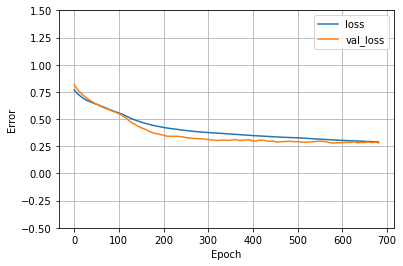

In [9]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([-0.5, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [10]:
test_results = model.evaluate(test_input, test_output, verbose=0)

In [38]:
print(f"Loss: {round(test_results[0]*100,2)}%")
print(f"Akurasi: {round(test_results[1]*100,2)}%")

Loss: 32.74%
Akurasi: 83.33%


# Banyak Data:

In [30]:
print(f"Total data: {len(df)}")
print(f"Banyak data training: {len(train_input)}")
print(f"Banyak data testing: {len(test_input)}")

Total data: 119
Banyak data training: 95
Banyak data testing: 24


# Menyimpan Model untuk Prediksi

In [31]:
model.save("model.h5")

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ariaw\AppData\Local\Temp\tmprs32_ope\assets


INFO:tensorflow:Assets written to: C:\Users\ariaw\AppData\Local\Temp\tmprs32_ope\assets


2640